In [1]:
# import packages 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

from tqdm import tqdm

In [2]:
# load data 
df = pd.read_csv('./scraped_data/elo_pfr_betting_data.csv')
df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)

# shift target column 
target = 'OU_RESULT'    # column name to predict

df = df[df['OU_RESULT'] != 2]

In [3]:
game_data_columns = []
for c in df.columns:
    if("home" in c or "away" in c):
        if('td' not in c and 'xp' not in c and 'fg' not in c):
            game_data_columns.append(c)

benchmark_data = df[game_data_columns]
benchmark_data['home_time_of_poss'] = benchmark_data['home_time_of_poss'].apply(lambda x: 60*float(x[:2]) + float(x[3:]))
benchmark_data['away_time_of_poss'] = benchmark_data['away_time_of_poss'].apply(lambda x: 60*float(x[:2]) + float(x[3:]))

/var/folders/mh/wfzfv8nd3g7_8w30_pjfbhtr0000gn/T/ipykernel_62101/117191939.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_data['home_time_of_poss'] = benchmark_data['home_time_of_poss'].apply(lambda x: 60*float(x[:2]) + float(x[3:]))
/var/folders/mh/wfzfv8nd3g7_8w30_pjfbhtr0000gn/T/ipykernel_62101/117191939.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_data['away_time_of_poss'] = benchmark_data['away_time_of_poss'].apply(lambda x: 60*float(x[:2]) + float(x[3:]))


In [4]:
test_start = int(df.shape[0]*0.8)
df_train = benchmark_data.loc[:test_start].copy()
df_train[target] = df.loc[:test_start][target]
df_test  = benchmark_data[test_start:].copy()
df_test[target] = df.loc[test_start:][target]

In [5]:
# Standardize features 
target_mean = df.loc[:test_start][target].mean()
target_stdev = df.loc[test_start:][target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [6]:
# Create a dataset that pytorch loader can work with 
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]
    
class NFLClassificationDataset(Dataset):
    def __init__(self, dataframe, target, features):
        self.features = features
        self.target = target
        self.y = torch.tensor(dataframe[target].values).long()
        self.X = torch.tensor(dataframe[features].values).float()
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [7]:
features = list(df_train.columns.difference([target]))
sequence_length = 16

train_dataset = NFLClassificationDataset(
    df_train,
    target=target,
    features=features,
)

test_dataset = NFLClassificationDataset(
    df_test,
    target=target,
    features=features,
)

In [8]:
# Set the dataset in pytorch dataloader
torch.manual_seed(99)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# hyperparameters
lr = 1e-3
epoch = 1000
input_size = len(features)
hidden_size = 32
dropout = 0.5

model = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.Dropout(dropout),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.Dropout(dropout),
    nn.ReLU(),
    nn.Linear(64,2),
    nn.Softmax(dim=1)
)

#loss_func = nn.MSELoss()
loss_func = nn.CrossEntropyLoss()
criterion = torch.optim.Adam(model.parameters(), lr = lr)

In [10]:
# Training 
def train(data, model, loss_func, optimizer):
    n_batches = len(data)
    total_loss = 0
    model.train()
    
    for x,y in data:
        output= model(x)
        loss = loss_func(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    mean_loss = total_loss/n_batches
    #print(f'Training loss: {mean_loss}')
    return mean_loss, model
    

def test(data,model,loss_func):
    n_batches = len(data)
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for x, y in data:
            output= model(x)
            total_loss += loss_func(output,y).item()
            
    mean_loss = total_loss/n_batches
    #print(f'Test loss: {mean_loss}')
    
    return mean_loss     

In [11]:
# prediction function
def predict(data, model):
    
    output = torch.tensor([])
    model.eval()
    
    with torch.no_grad():
        for X,_ in data:
            y_fit = model(X)
            output = torch.cat((output,y_fit), 0)
    
    return output

  0%|                                                                       | 0/1000 [00:00<?, ?it/s]/Users/clo/miniforge3/envs/nflbetting/lib/python3.10/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
  0%|▎                                                              | 4/1000 [00:00<00:55, 17.93it/s]

TRAIN LOSS: 0.64667
TEST LOSS: 0.57056


 10%|██████▏                                                      | 102/1000 [00:05<00:49, 18.27it/s]

TRAIN LOSS: 0.48671
TEST LOSS: 0.55019


 20%|████████████▎                                                | 202/1000 [00:11<00:44, 17.80it/s]

TRAIN LOSS: 0.47498
TEST LOSS: 0.54841


 30%|██████████████████▍                                          | 302/1000 [00:17<00:39, 17.64it/s]

TRAIN LOSS: 0.46011
TEST LOSS: 0.55604


 40%|████████████████████████▌                                    | 402/1000 [00:23<00:36, 16.52it/s]

TRAIN LOSS: 0.45506
TEST LOSS: 0.56078


 50%|██████████████████████████████▌                              | 502/1000 [00:28<00:27, 18.22it/s]

TRAIN LOSS: 0.44819
TEST LOSS: 0.56109


 60%|████████████████████████████████████▋                        | 602/1000 [00:34<00:23, 16.93it/s]

TRAIN LOSS: 0.44423
TEST LOSS: 0.55546


 70%|██████████████████████████████████████████▊                  | 702/1000 [00:40<00:16, 18.43it/s]

TRAIN LOSS: 0.43841
TEST LOSS: 0.55709


 80%|████████████████████████████████████████████████▉            | 802/1000 [00:45<00:10, 18.10it/s]

TRAIN LOSS: 0.44315
TEST LOSS: 0.56885


 90%|███████████████████████████████████████████████████████      | 902/1000 [00:52<00:06, 15.96it/s]

TRAIN LOSS: 0.43385
TEST LOSS: 0.56655


100%|████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.37it/s]

TRAIN LOSS: 0.44033
TEST LOSS: 0.56383


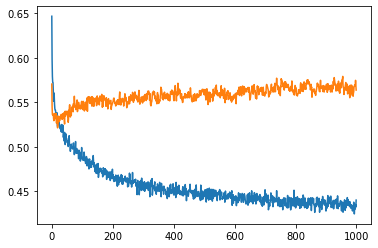

In [12]:
# Run lstm 
trainloss = []
testloss = []
for i in tqdm(range(epoch)):
    train_loss, model = train(train_loader, model, loss_func, optimizer=criterion)
    trainloss.append(train_loss)
    test_loss  = test(test_loader, model, loss_func)
    testloss.append(test_loss)    
    if(((i+1)%100) == 0 or (i == 0)):
        print("TRAIN LOSS: {0:.5f}".format(train_loss))
        print("TEST LOSS: {0:.5f}".format(test_loss))

fig, ax = plt.subplots()
ax.plot(trainloss)
ax.plot(testloss)
plt.show()

In [62]:
def evaluate(data, model):
    preds, labels = [], []
    with torch.no_grad():
        for x, y in data:
            labels.append(y.item())
            preds.append(model(x).argmax().item())
            
    acc = 100*sum(np.array(preds) == np.array(labels))/len(preds)
    print("CLASSIFICATION ACCURACY: {0:.3f}%".format(acc))
    return acc
            
evaluate(test_dataset, model)

CLASSIFICATION ACCURACY: 75.119%


/Users/clo/miniforge3/envs/nflbetting/lib/python3.10/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


75.1188589540412

## Bayesopt

In [63]:
def get_datasets(batch_size=16):
    
    # Get dataset
    test_start = int(df.shape[0]*0.8)
    valid_start = int(df.shape[0]*0.64)
    df_train = benchmark_data.loc[:valid_start].copy()
    df_valid = benchmark_data.loc[valid_start:test_start].copy()
    df_test  = benchmark_data[test_start:].copy()
    
    # Standardize features 
    for c in df_train.columns:
        mean = df_train[c].mean()
        stdev = df_train[c].std()

        df_train[c] = (df_train[c] - mean) / stdev
        df_valid[c] = (df_valid[c] - mean) / stdev
        df_test[c] = (df_test[c] - mean) / stdev
        
    df_train[target] = df.loc[:test_start][target]
    df_valid[target] = df.loc[valid_start:test_start][target]
    df_test[target] = df.loc[test_start:][target]
    
    features = list(df_train.columns.difference([target]))
    train_dataset = NFLClassificationDataset(df_train, target=target, features=features)
    valid_dataset = NFLClassificationDataset(df_valid, target=target, features=features)
    test_dataset = NFLClassificationDataset(df_test, target=target, features=features)
    
    torch.manual_seed(99)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    return train_loader, valid_loader, test_loader

def get_model(lr, features, hidden_size, dropout, layers):
    # hyperparameters
    lr = lr
    input_size = len(features)
    hidden_size = hidden_size
    dropout = dropout
    layers = layers

    # Build model
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU()
    )
    for l in range(layers):
        model.append(nn.Linear(hidden_size, hidden_size))
        model.append(nn.Dropout(dropout))
        model.append(nn.ReLU())
    model.append(nn.Linear(hidden_size, 2))
    model.append(nn.Softmax(dim=1))

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    return model, optimizer

In [64]:
def target_function(lr=-3, epoch=1000, hidden_size=32, layers=3, dropout=0.5, batch_size=16):
    
    train_loader, valid_loader, test_loader = get_datasets(batch_size=int(batch_size))
    model, optimizer = get_model(10**lr, features, int(hidden_size), dropout, int(layers))
    loss_func = nn.CrossEntropyLoss()
    
    # Run lstm 
    trainloss = []
    valloss = []
    for i in tqdm(range(int(epoch))):
        train_loss, model = train(train_loader, model, loss_func, optimizer=criterion)
        trainloss.append(train_loss)
        val_loss  = test(valid_loader, model, loss_func)
        valloss.append(val_loss)    
        #if(((i+1)%100) == 0 or (i == 0)):
        #    print("TRAIN LOSS: {0:.5f}".format(train_loss))
        #    print("TEST LOSS: {0:.5f}".format(val_loss))

    return evaluate(valid_loader, model)

In [65]:
from bayes_opt import BayesianOptimization

pbounds = {
    'lr': (-10,-1),
    'epoch': (10, 2000),
    'hidden_size': (1, 256),
    'layers': (1, 7),
    'dropout': (0.0, 1.0),
    'batch_size': (1, 128),
}

optimizer = BayesianOptimization(
    f=target_function,
    pbounds=pbounds,
    random_state=1
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=3
)

|   iter    |  target   | batch_... |  dropout  |   epoch   | hidden... |  layers   |    lr     |
-------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.78it/s]


CLASSIFICATION ACCURACY: 54.781%
|  1        |  54.78    |  53.96    |  0.7203   |  10.23    |  78.09    |  1.881    | -9.169    |


 34%|████████████████████▊                                         | 269/799 [00:43<01:25,  6.18it/s]